In [1]:
#pip install torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
#pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
input_size = 784 # 28x28
hidden_size = 500 
num_classes = 10
num_epochs = 3
batch_size = 4
learning_rate = 0.001

In [6]:
# Import MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



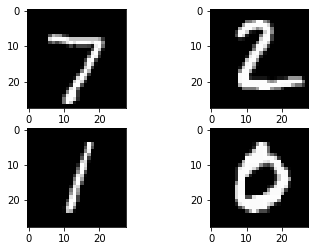

In [8]:
examples = iter(test_loader)
example_data, example_targets = examples.__next__()

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

In [9]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential( nn.Conv2d(1,64,kernel_size = 3),
                                 nn.ReLU(),
                                 nn.MaxPool2d((2,2), stride = 2),
                                 nn.Conv2d(64,128,kernel_size = 3),
                                 nn.ReLU(),
                                 nn.MaxPool2d((2,2), stride = 2),
                                 nn.Conv2d(128,64,kernel_size = 3),
                                 nn.ReLU(),
                                 nn.MaxPool2d((2,2), stride = 2),
                                )
        self.classification_head = nn.Sequential(
                                nn.Linear(64,20,bias = True),
                                nn.ReLU(),
                                nn.Linear(20,10,bias = True)
                                )
    def forward(self, x):
        features = self.net(x)
        return self.classification_head(features.view(batch_size, -1))

In [10]:
model = CNNClassifier().to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
def save_checkpoint(cp, filename):
    torch.save(cp, filename)

In [14]:
# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    
    if(epoch == 2):
        checkpoint = {'model': model.state_dict(),
                     'optim': optimizer.state_dict(),
                      'loss': loss,
                      'epoch_num': epoch
                     }
        save_checkpoint(checkpoint, 'my_saved_check.pt')
    
    for i, (images, labels) in enumerate(train_loader): 
        
        # origin shape: [4, 1, 28, 28]
        # resized: [4, 784]
        #images = images.reshape(-1, 28*28).to(device)
        
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/3], Loss: 0.0010
Epoch [2/3], Loss: 0.0000
Epoch [3/3], Loss: 0.0001


In [16]:
def acc_check(loader):
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in loader:
            #images = images.reshape(-1, 28*28).to(device)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')

In [19]:
print("Training accuracy:\n") 
acc_check(train_loader)
print("Testing accuracy:\n") 
acc_check(test_loader)

Training accuracy:

Accuracy of the network on the 10000 test images: 99.36333333333333 %
Testing accuracy:

Accuracy of the network on the 10000 test images: 98.51 %


# Part 2:

In [69]:
from torch.utils.data import Dataset, DataLoader

In [70]:
def genGaussian(tindx):
    return torch.normal(tindx[0], tindx[1], (1,28,28))

class myDataset(Dataset):
    def __init__(self, n):
        classes = {0: (0.5, 2), 1: (1, 2.5)}
        self.y = [torch.round(torch.rand(1))[0].long() for i in range(n)]
        self.x = [genGaussian(classes[self.y[i].item()]) for i in range(n)]
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return len(self.x)

In [93]:
data = myDataset(20) #generating data

In [94]:
dataloader = torch.utils.data.DataLoader(dataset=data, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [101]:
for i, d in enumerate(dataloader):
    print(i, d)
    break

0 [tensor([[[[ 0.7447,  3.0993,  1.7513,  ...,  0.5454, -3.0765,  3.8262],
          [-2.9133,  0.1206, -2.4121,  ...,  2.1893, -1.5133,  0.5616],
          [ 0.4317,  0.7325,  2.0999,  ...,  3.8638,  0.6724, -0.6132],
          ...,
          [ 3.3274, -2.3565,  2.6706,  ..., -0.9579,  0.3819, -1.2408],
          [ 0.7610, -3.1219,  0.6756,  ..., -1.8285, -1.2630, -1.3972],
          [-0.1652,  0.9302, -1.0886,  ...,  0.9017,  3.2513,  1.4431]]],


        [[[-3.1905,  2.0222, -0.3588,  ...,  7.2604,  1.8907, -3.4143],
          [ 5.7692,  2.3903,  1.8191,  ...,  3.8136,  5.5115,  7.4887],
          [ 3.5587,  2.3749,  2.0306,  ..., -0.4546,  1.3477, -2.4495],
          ...,
          [ 1.8027,  2.8814, -0.3936,  ...,  1.5548, -0.7242, -2.4506],
          [ 1.2066,  0.0815, -0.2797,  ..., -4.1345, -2.4537, -0.7404],
          [-1.4129, -0.6807,  2.9352,  ...,  1.2528,  0.7097, -2.4006]]],


        [[[ 5.7157,  1.3162,  5.3412,  ..., -3.0697,  1.2970,  1.5401],
          [ 2.6654, -0.

In [116]:
model = CNNClassifier().to(device)

In [117]:
checkpoint = torch.load('my_saved_check.pt')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optim'])
epoch = checkpoint['epoch_num']
loss = checkpoint['loss']

In [118]:
#editing model parameters
model.classification_head = nn.Sequential(
                                nn.Linear(64,20,bias = True),
                                nn.ReLU(),
                                nn.Linear(20,2,bias = True)
                                )

In [119]:
print(model)

CNNClassifier(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification_head): Sequential(
    (0): Linear(in_features=64, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=2, bias=True)
  )
)


In [124]:
model = model.to(device)

In [125]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [126]:
n_total_steps = len(data)

In [127]:
#training the model again:

for epoch in range(num_epochs):
    
    for i, (images, labels) in enumerate(dataloader): 
        
        # origin shape: [4, 1, 28, 28]
        # resized: [4, 784]
        #images = images.reshape(-1, 28*28).to(device)
        
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/3], Loss: 0.9644
Epoch [2/3], Loss: 0.3182
Epoch [3/3], Loss: 0.0609


In [128]:
#checking accuracy of new model:
def acc_check(loader):
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in loader:
            #images = images.reshape(-1, 28*28).to(device)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')

In [129]:
acc_check(dataloader)

Accuracy of the network: 95.0 %
